In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import re
import os
import tensorflow as tf
import tensorflow.nn as nn
import tensorflow.keras as keras
from keras.applications.nasnet import NASNetMobile

from PIL import Image
import cv2

Using TensorFlow backend.


## 【問題1】自作データセットでの分類の学習

In [2]:
path = '../image'

image_list = [name for name in os.listdir(path) if not name.startswith('.') and name.endswith('.jpg')]
print(image_list)

['dog5.jpg', 'dog4.jpg', 'dog3.jpg', 'dog2.jpg', 'dog1.jpg', 'cat1.jpg', 'cat2.jpg', 'cat3.jpg', 'cat4.jpg', 'cat5.jpg']


In [3]:
dog_img_array = np.empty((0,224,224,3))
cat_img_array = np.empty((0,224,224,3))

for img in image_list:
    if re.search('dog', img):
        dog_img_ = Image.open(str(path)+'/'+img)
        dog_img_ = dog_img_.resize((224,224))
        dog_img = np.array(dog_img_)
        
        dog_img = dog_img / 255.
        dog_img = dog_img.reshape((1,224,224,3))
        dog_img_array = np.concatenate([dog_img_array, dog_img], axis=0)
    
    if re.search('cat', img):
        cat_img_ = Image.open(str(path)+'/'+img)
        cat_img_ = cat_img_.resize((224,224))
        cat_img = np.array(cat_img_)
        
        cat_img = cat_img / 255.
        cat_img = cat_img.reshape((1,224,224,3))
        cat_img_array = np.concatenate([cat_img_array, cat_img], axis=0)

In [4]:
print('dog_image:{} cat_image:{}'.format(dog_img_array.shape, cat_img_array.shape))

dog_image:(5, 224, 224, 3) cat_image:(5, 224, 224, 3)


In [5]:
input_img = np.concatenate((dog_img_array, cat_img_array), axis=0)
label = np.array([1,1,1,1,1,0,0,0,0,0])

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(input_img, label, test_size=0.4, shuffle=True, stratify=label)

In [7]:
input_data = keras.layers.Input(shape=(224,224,3))
nasnet = keras.applications.nasnet.NASNetMobile(input_tensor=input_data, weights='imagenet', include_top=False)

top_model = keras.models.Sequential()
top_model.add(keras.layers.Flatten(input_shape=nasnet.output_shape[1:]))
top_model.add(keras.layers.Dense(128, activation=nn.relu))
top_model.add(keras.layers.Dropout(0.25))
top_model.add(keras.layers.Dense(1, activation=nn.sigmoid))

model = keras.Model(inputs=nasnet.input, outputs=top_model(nasnet.output))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=6, epochs=10,
                    verbose=1, validation_data=[X_valid, y_valid])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6 samples, validate on 4 samples
Epoch 1/10
6/6 [==============================] - 99s 17s/sample - loss: 1.1991 - acc: 0.3333 - val_loss: 43.6827 - val_acc: 0.5000
Epoch 2/10
6/6 [==============================] - 4s 728ms/sample - loss: 45.7234 - acc: 0.5000 - val_loss: 272.9167 - val_acc: 0.5000
Epoch 3/10
6/6 [==============================] - 4s 671ms/sample - loss: 85.1028 - acc: 0.5000 - val_loss: 116096.1250 - val_acc: 0.5000
Epoch 4/10
6/6 [==============================] - 4s 693ms/sample - loss: 1.4168 - acc: 0.6667 - val_loss: 97145792.0000 - val_acc: 0.5000
Epoch 5/10
6/6 [==============================] - 4s 661ms/sample - loss: 1.5741 - acc: 0.8333 - val_loss: 5296900096.0000 - val_acc: 0.5000
Epoch 6/10
6/6 [==============================] - 3s 539ms/sample - loss: 1.7624 - acc: 0.6667 - val_loss: 74019479552.0000 - val_acc: 0.5000
Epoch 7/10
6/6 [=====================

## 【問題2】分類データセットに対するデータ拡張

In [9]:
import albumentations as albu
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    ChannelShuffle, JpegCompression, MultiplicativeNoise, Cutout,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, BboxParams
)

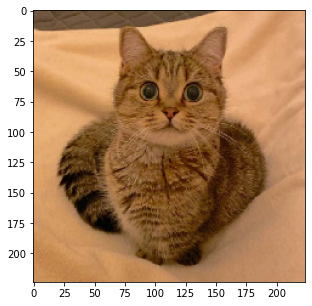

In [10]:
image = X_train[0]

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.show()

In [11]:
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    return image

In [12]:
def strong_aug(p=.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        Blur(blur_limit=3, p=0.3),
        ChannelShuffle(p=0.3),
        MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=0.3),
        Cutout(num_holes=10, max_h_size=30, max_w_size=30, fill_value=255, p=0.3),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        IAASharpen(p=0.3),
    ], p=p)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

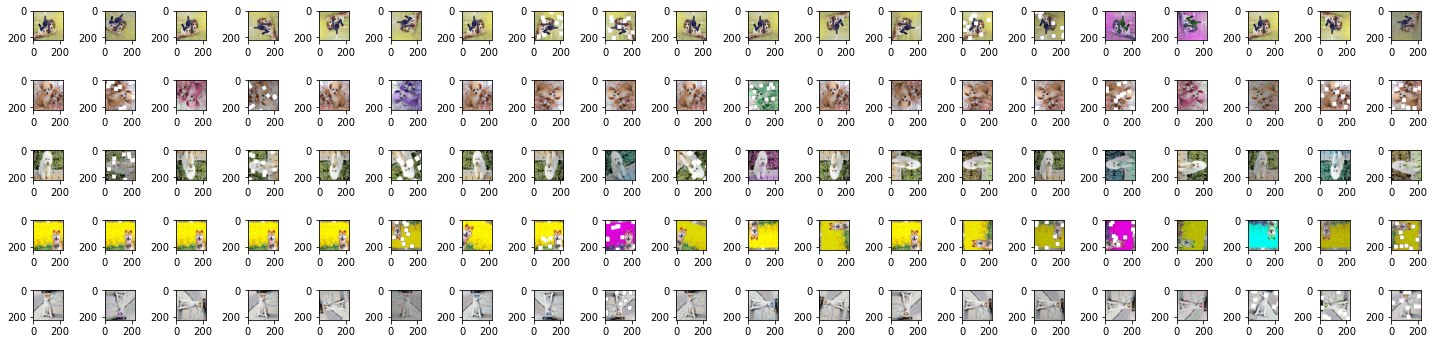

In [13]:
aug = strong_aug(p=0.9)
dog_list = []

fig, axs = plt.subplots(5, 20, figsize=(20, 5))
for i, image in enumerate(dog_img_array):
    dog_list.append(image)
    axs[i][0].imshow(image)
    for j in range(1,20):
        aug_image = aug(image=image)['image']
        dog_list.append(aug_image)
        axs[i][j].imshow(aug_image)
plt.tight_layout();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

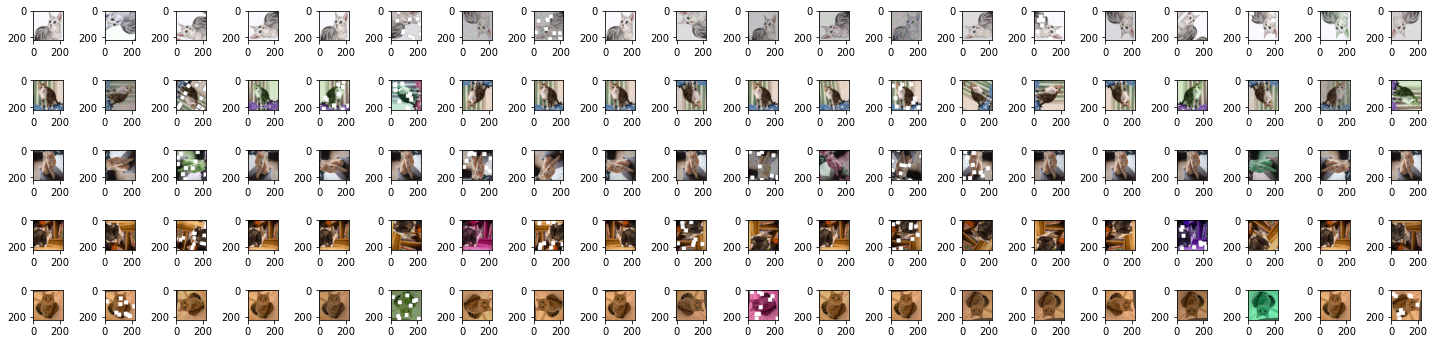

In [14]:
aug = strong_aug(p=0.9)
cat_list = []

fig, axs = plt.subplots(5, 20, figsize=(20, 5))
for i, image in enumerate(cat_img_array):
    dog_list.append(image)
    axs[i][0].imshow(image)
    for j in range(1,20):
        aug_image = aug(image=image)['image']
        cat_list.append(aug_image)
        axs[i][j].imshow(aug_image)
plt.tight_layout();

## 【問題3】物体検出データセットの用意

In [15]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = bbox
#     x_min, y_min, w, h = bbox
#     x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='pascal_voc', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

In [16]:
cat_img_ = Image.open('../image/cat1.jpg')
np.array(cat_img_).shape

(1200, 1600, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


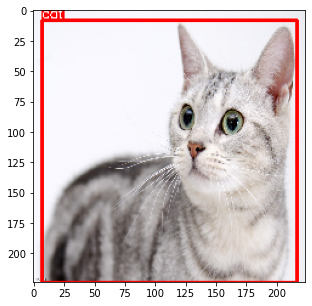

In [17]:
image = cat_img_array[0]
bbox1 = np.array([int(50/1600*224), int(46/1200*224), int(1553/1600*224), int(1200/1200*224)]).tolist()

annotations = {'image': image, 'bboxes': [bbox1], 'category_id': [0]}
category_id_to_name = {0: 'cat', 1: 'dog'}
visualize(annotations, category_id_to_name)

## 【問題4】物体検出データセットに対するデータ拡張

In [18]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='pascal_voc', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

In [19]:
image = cat_img_array[0]
bbox1 = np.array([int(50/1600*224), int(46/1200*224), int(1553/1600*224), int(1200/1200*224)]).tolist()
annotations = {'image': image, 'bboxes': [bbox1], 'category_id': [0]}
category_id_to_name = {0: 'cat', 1: 'dog'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


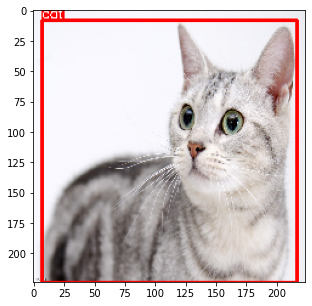

In [20]:
visualize(annotations, category_id_to_name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


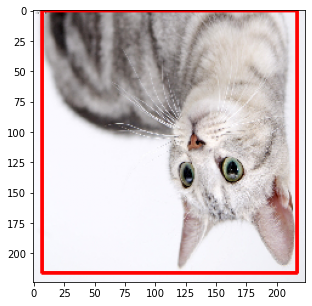

In [35]:
aug = get_aug([VerticalFlip(p=1)])
augmented = aug(**annotations)

# bboxesの中がintのiterじゃないとエラーになったので
lst = []
for n, i in enumerate(augmented['bboxes'][0]):
    lst += [int(i)]
augmented['bboxes'][0] = lst

visualize(augmented, category_id_to_name)